In [0]:
%matplotlib inline
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
# !pip install tensorflow-gpu==2.0.0-beta1
# !pip install --upgrade keras
import tensorflow as tf


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
# from keras_radam import RAdam    # try

# 1. 讀入 Fashion MNSIT 數據集

In [0]:
from tensorflow.keras.datasets import fashion_mnist

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# 看一下shape
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [0]:
y_train[0]

9

# 2. 欣賞數據集內容

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

這是 Bag


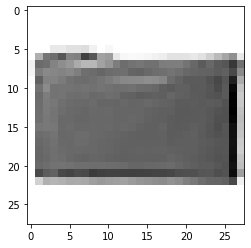

In [0]:
n = 1234
print('這是', class_names[y_train[n]])
plt.imshow(x_train[n], cmap='Greys');

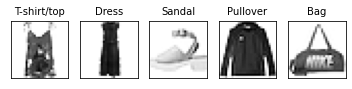

In [0]:
pick = np.random.choice(60000, 5, replace=False)    # 抽出不放回

for i in range(5):
    n = pick[i]
    ax = plt.subplot(151+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[y_train[n]], fontsize=10)
    plt.imshow(x_train[n], cmap='Greys')  

In [0]:
pick

array([   67, 34128, 51419, 59536, 49682])

## 前處理

In [0]:
# parameters
class_nums = len(class_names)


# flatten and normalize
x_train = x_train.reshape(60000, 784) / 255.
x_test = x_test.reshape(10000, 784) / 255.

x_train_original = x_train.reshape(60000, 28, 28, 1)
x_test_original = x_test.reshape(10000, 28, 28, 1)


# one-hot y-data
y_train = tf.keras.utils.to_categorical(y_train, class_nums)
y_test = tf.keras.utils.to_categorical(y_test, class_nums)

## Model
- CNN model
    - baseline
        - 卷積層3層
    - activation一般都是用Relu, 用性質相近的leaky relu如何?
        - relu
        - leaky relu
    - BatchNormalization要不要加，以及為什麼?加在哪?
        - [BN在前還是activation在前](https://arxiv.org/pdf/1603.05027.pdf)
            - 早期是BN在前，後面的論文研究BN在activation效果可能好一些。
    - pooling要不要加，以及為什麼?
        - MaxPooling
            - MaxPooling 通常會在幾層 Convolution 後，⽤來降低 Feature Maps 的尺度以及強化特徵。
        - AveragePooling
    - optimizer要使用哪一個，以及為什麼?
        - SGD
        - Adam
        - RMSP
    - initializer要使用哪一種方式，以及為什麼?
        - default
        - others
    - Flatten與GlobalAveragePooling差別在哪裡?要用哪一個?
        - Flatten
        - GlobalAveragePooling
            - Global Average Pooling (GAP) 就是將每張Feature Map上的資訊以平
均的⽅式壓為⼀個值
                - 好處是什麼???
    - loss function要用哪一個，以及為什麼?
        - mse
        - binary_crose_entropy
    - early-stop
    - maybe data augmentation or transfering learnging


## Baseline CNN Model
- #### 表現就不會太差了, 可以有一個直覺說, 淺層模型就足夠學到大部分的線條。

In [0]:
# baseline
# 5s 10ms/step - loss: 0.0056 - accuracy: 0.9649 - val_loss: 0.0138 - val_accuracy: 0.9095
# 明顯可以觀察到overfitting

batch_size = 128
epochs = 20
# lr = 0.01

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', 
                 input_shape=x_train_original.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='mse',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.fit(x_train_original, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_original, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

## 檢驗activation function效果
- 效果兩者是差不多的，可能是因為此情形沒有dead neuron。
    - 因此，維持原選擇relu，因為計算量還比較少。
- [參考常用激勵函數以及如何選擇](https://blog.csdn.net/tyhj_sf/article/details/79932893)

In [0]:
batch_size = 128
epochs = 20

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', 
                 input_shape=x_train_original.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='mse',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.fit(x_train_original, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_original, y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

## 測試initializer變換
    - uniform
    - defalut
    - 結論: 兩者沒有太顯著的差異，當然這是很初步的測試，並沒有去調整其他lr等等來比較。
        - 暫時維持原default的initializer
        - 猜想: 在訓練參數大時, 理論上會有所差距。

In [0]:
batch_size = 128
epochs = 20

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', 
                 input_shape=x_train_original.shape[1:],
                 activation='relu',
                 kernel_initializer='uniform'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same',
                 activation='relu',
                 kernel_initializer='uniform'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same',
                 activation='relu',
                 kernel_initializer='uniform'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu',
                kernel_initializer='uniform'))
model.add(Dense(10, activation='softmax',
                kernel_initializer='uniform'))
model.summary()

model.compile(loss='mse',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.fit(x_train_original, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_original, y_test))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)              

## 測試Pooling的效果
- 有MaxPooling
    - 參數減少非常多。
    - 著重最顯著的特徵, 也比較符合一般的視覺直覺。
- 沒有MaxPooling
    - 參數多，訓練速度慢。
    - 更為嚴重的overfitting, 但acc也是有所提升。
- 有AveragePooling
    - 參數同MaxPooling
    - 相對於MaxPooling, 會柔和特徵。

- 結論:
    - 結果還是MaxPooling更好一些。
        - 參數少, acc也是表現得比averagePooling更好一些。
        - 但，這只是在"全部"都放相同的狀況下, 如果根據更深的CNN model
            去做適當的放置, 我認為可能會表現得比單純全部都一樣好。
            - 這些測試還沒有做, work有點太多QQ

In [0]:
batch_size = 128
epochs = 20

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', 
                 input_shape=x_train_original.shape[1:],
                 activation='relu'))
# model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same',
                 activation='relu'))
# model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same',
                 activation='relu'))
# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='mse',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.fit(x_train_original, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_original, y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 6,447,242
Trainable params: 6,447,242
Non-trainable params: 0
____________________________________________

## Optimizer測試
- RMSprop
- Adam
- SGD
- 結論
    - 這邊就不列出測試, 但幾乎就是Adam表現最好, 參數都是default
    - 有參考許多文章, 幾乎Adam的穩定度都是大家所推崇。

In [0]:
batch_size = 128
epochs = 20
# lr = 0.01

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', 
                 input_shape=x_train_original.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='mse',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.fit(x_train_original, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_original, y_test))

## Flatten vs GlobalAveragePooling
- Flatten
- GlobalAveragePooling
    - 參數少，會有特徵壓縮效果。
    - 效果比起Flatten, overfitting情況較小, 但acc也下降了。

In [0]:
# GlobalAveragePooling
# 參數少很多, 但可想而知會失去一些特徵

batch_size = 128
epochs = 20

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', 
                 input_shape=x_train_original.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same',
                 activation='relu'))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='mse',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.fit(x_train_original, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_original, y_test))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)               

## 深度加深 + Dropout

In [0]:
# 超參數
batch_size = 128
epochs = 20

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=x_test_original.shape[1:]))   # (60000, 28, 28, 1)
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='mse',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train_original, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_original, y_test),
                    steps_per_epoch=None)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 26, 26, 32)        4640      
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 64)      

In [0]:
# 超參數
# 沒有BN: 5s 80us/sample - loss: 0.0038 - accuracy: 0.9765 - val_loss: 0.0117 - val_accuracy: 0.9276
# 有BN: 7s 120us/sample - loss: 0.0040 - accuracy: 0.9747 - val_loss: 0.0110 - val_accuracy: 0.9317
# 有BN+Dense(1024): 8s 129us/sample - loss: 0.0047 - accuracy: 0.9709 - val_loss: 0.0113 - val_accuracy: 0.9329
# BN+512+32: 7s 113us/sample - loss: 0.0044 - accuracy: 0.9722 - val_loss: 0.0110 - val_accuracy: 0.9309
# 多了1x1 CNN: 8s 131us/sample - loss: 0.0041 - accuracy: 0.9740 - val_loss: 0.0118 - val_accuracy: 0.9277
# 比原始還少一層 earlystop在16 : 6s 98us/sample - loss: 0.0062 - accuracy: 0.9594 - val_loss: 0.0124 - val_accuracy: 0.9210

# lr=0.01, 超爛: 7s 123us/sample - loss: 0.0249 - accuracy: 0.8738 - val_loss: 0.0254 - val_accuracy: 0.8718
# lr=0.002, 8s 133us/sample - loss: 0.0051 - accuracy: 0.9683 - val_loss: 0.0109 - val_accuracy: 0.9321
# default還比較好= =

# MaxPooling x3, 原本只有一個: 6s 106us/sample - loss: 0.0152 - accuracy: 0.8974 - val_loss: 0.0158 - val_accuracy: 0.8908

# 原32-32-64
# 32-64-128: 10s 159us/sample - loss: 0.0039 - accuracy: 0.9758 - val_loss: 0.0121 - val_accuracy: 0.9253
# 16-32-64: 7s 120us/sample - loss: 0.0038 - accuracy: 0.9762 - val_loss: 0.0108 - val_accuracy: 0.9322
# 64-128-256: overfitting : 15s 246us/sample - loss: 0.0025 - accuracy: 0.9850 - val_loss: 0.0108 - val_accuracy: 0.9313

batch_size = 128
epochs = 20


model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',               
                 input_shape=x_test_original.shape[1:]))   # (60000, 28, 28, 1)  # 原filter=32
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))    
model.add(Conv2D(128, (3, 3)))                  #
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



model.add(Conv2D(256, (3, 3), padding='same'))     # 修改, 原64
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))      # 修改
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# callback
earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=5, 
                          verbose=1
                          )


model.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy']
              )

history = model.fit(x_train_original, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_original, y_test),
                    steps_per_epoch=None,
                    callbacks=[earlystop])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
activation_13 (Activation)   (None, 12, 12, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)     

In [0]:
batch_size = 128
epochs = 20


model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',               
                 input_shape=x_test_original.shape[1:]))  
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))    
model.add(Conv2D(128, (3, 3)))                  
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



model.add(Conv2D(256, (3, 3), padding='same'))  
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256))      # 修改
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

# callback
earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=5, 
                          verbose=1
                          )


model.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy']
              )

history = model.fit(x_train_original, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_original, y_test),
                    steps_per_epoch=None,
                    callbacks=[earlystop])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
activation_17 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
activation_18 (Activation)   (None, 12, 12, 128)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 128)     

## 結論
- 加深acc會提高，但訓練速度也會減慢許多，在目前計算資源有限下, 我沒有繼續加深測試。
- Adam優化器表現上還是比較優秀的，但lr我並沒有調整，這也是可以測試的項目之一。
- MaxPooling2D表現較好, 但實際真實意義需要去看paper才能完整了解, 暫時沒有。
- 理論上, 專為二元分類的損失函數表現會比較好, 但測試結果並沒有顯著差異。
- 其餘測試結果如上次全連結差不多。
- 我就沒有去測試一些RESNET等經典模型, 之後可以考慮用經典模型去測試。
    - 如1x1的特徵汲取等等。